In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.tree import DecisionTreeClassifier

In [4]:
df = pd.read_csv('train_pipeline.csv')

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Strategy
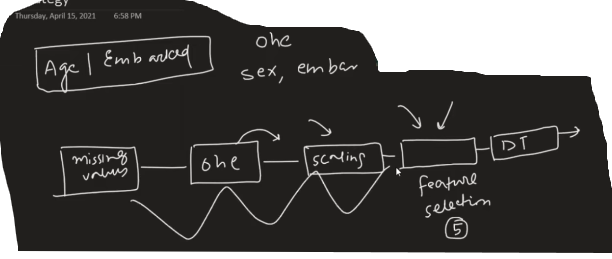

In [6]:
df.drop(columns=['PassengerId','Name','Ticket','Cabin'],inplace=True)

In [7]:
# Step 1 -> train/test/split
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['Survived']),
                                                 df['Survived'],
                                                 test_size=0.2,
                                                random_state=42)

In [8]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,male,45.5,0,0,28.5000,S
733,2,male,23.0,0,0,13.0000,S
382,3,male,32.0,0,0,7.9250,S
704,3,male,26.0,1,0,7.8542,S
813,3,female,6.0,4,2,31.2750,S


In [9]:
y_train.sample(4)

823    1
40     0
167    0
248    1
Name: Survived, dtype: int64

In [10]:
#imputation transfomer
trf1 = ColumnTransformer([
    ('impute_age',SimpleImputer(),[2]),
    ('impute_embarked',SimpleImputer(strategy='most_frequent'),[6])
],remainder='passthrough')

In [18]:
# one hot encoding
trf2 = ColumnTransformer([
    ('ohe_sex_embarked',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),[1,6])
],remainder='passthrough')

In [19]:
# Scaling
trf3 = ColumnTransformer([
    ('scale',MinMaxScaler(),slice(0,10))
])

In [20]:
# Feature selection
trf4 = SelectKBest(score_func=chi2,k=8)

In [21]:
# train the model
trf5 = DecisionTreeClassifier()

## Create Pipeline

In [73]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
    ('trf4',trf4),
    ('trf5',trf5) 
])

## Pipeline Vs make_pipeline - 
Pipeline requires naming of steps, make_pipeline does not

(Same applies to ColumnTransformer vs make_column_transformer)

In [74]:
# Alternate system
pipe = make_pipeline(trf1,trf2,trf3,trf4,trf5)

In [75]:
#train 
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  [2]),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [6])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_sex_embarked',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [1, 6])])),
                ('columntransformer-3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 10, None))])),
                ('selectkbest',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x000001E1E9CE61F0>)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

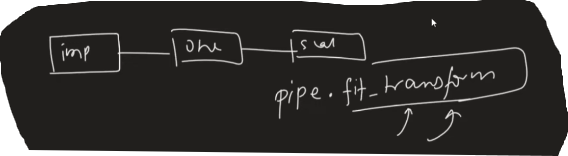

# Explore the Pipeline

In [76]:
# Display Pipeline

from sklearn import set_config
set_config(display='diagram')

In [77]:
# Code here
pipe.named_steps

{'columntransformer-1': ColumnTransformer(remainder='passthrough',
                   transformers=[('impute_age', SimpleImputer(), [2]),
                                 ('impute_embarked',
                                  SimpleImputer(strategy='most_frequent'),
                                  [6])]),
 'columntransformer-2': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_sex_embarked',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  [1, 6])]),
 'columntransformer-3': ColumnTransformer(transformers=[('scale', MinMaxScaler(), slice(0, 10, None))]),
 'selectkbest': SelectKBest(k=8, score_func=<function chi2 at 0x000001E1E9CE61F0>),
 'decisiontreeclassifier': DecisionTreeClassifier()}

In [78]:
# predict
y_pred = pipe.predict(X_test)

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6256983240223464

## Cross Validation using Pipeline

In [80]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.6391214419383433

## GridSearch using Pipeline

In [85]:
# gridsearchcv
params = {
    'trf5__max_depth':[1,2,3,4,5,None]
}

In [89]:
# pipe.get_params().keys()

In [90]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

ValueError: Invalid parameter 'trf5' for estimator Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  [2]),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [6])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_sex_embarked',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [1, 6])])),
                ('columntransformer-3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 10, None))])),
                ('selectkbest',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x000001E1E9CE61F0>)),
                ('decisiontreeclassifier', DecisionTreeClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [91]:
grid.best_score_


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
# grid.best_params_